# Deploy Your Model To Live Trading

## About Me
<img src="images/yv_logo_light.png" alt="logo" style="width: 200px;margin: 0 auto;"/>

## The Problems We Encounter in Deploying the Model to Live Trading

- Without Python API for Linux
- Hard to handle multiple contracts
- Large-scale tick data with continuous trading after 2020.03.23

## Let’s Deploy the Model

### Demo Case

## Model Architecture Overview

<img src="images/model_overview.svg" alt="model" style="margin: 0 auto;"/>

<img src="images/model.png" alt="model" style="height: 720px;margin: 0 auto;"/>

### Convolution Part for Tick TimeSeries

<img src="images/conv.svg" alt="model" style="margin: 0 auto;"/>

### Fully Connected Part for Domain Knowledge Features

- Cumulative Ask vs Bid side deal volume difference ratio
- Opening price change percentage
- Remaining trading hours of the day

### Concat Above Two Features' Extractor and Connect Below Fully Connected

<img src="images/concat.svg" alt="model" style="margin: 0 auto;"/>

### Take the Top 100 Volume of TSE Stock as Target

<img src="images/filter.svg" alt="model" style="height: 200px;margin: 0 auto;"/>

### How About Realtime Data?

#### Let's use shioaji

In [5]:
! pip install shioaji

In [6]:
import shioaji as sj

api = sj.Shioaji()
api.login(person_id="", passwd="")

@api.quote.on_quote
def quote_callback(topic: str, quote: dict):
    print(f"Topic: {topic}, Quote: {quote}")

Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up
Response Code: 200 | Event Code: 16 | Info: MKT/*/TSE/2330 | Event: Subscribe or Unsubscribe ok


In [ ]:
api.quote.subscribe(api.Contracts.Stocks["2330"])

In [7]:
api.quote.unsubscribe(api.Contracts.Stocks["2330"])

Response Code: 200 | Event Code: 16 | Info: MKT/*/TSE/2330 | Event: Subscribe or Unsubscribe ok


### Use Pure Python to Engage the Model

- init conv input, fc input cache, model, and api

In [8]:
class StreamModel:
    def __init__(self, codes: list, mode_path: str, threshold: float, api: sj.Shioaji):
        self.raw_ticks_dict = defaultdict(list)
        self.open_records = {}
        self.ask_vol_records = {code: 0 for code in codes}
        self.bid_vol_records = {code: 0 for code in codes}
        self.input_conv = {code: np.zeros((128, 1, 1)) for code in codes}
        self.input_fc = {code: np.zeros((3,)) for code in codes}
        self.model = load_model(mode_path)
        self.threshold = threshold
        self.api = api

- define on-quote handler 

In [ ]:
    def on_quote_handler(self, topic: str, quote: dict):
        if not quote.get("SimTrade"):
            symbol_code = topic.split('/')[-1]
            if symbol_code not in self.open_records:
                self.open_records[symbol_code] = quote["Close"][0]
            self.raw_ticks_dict[symbol_code].append({k: v[0] if isinstance(v, list) else v 
                                                     for k, v in quote.items()})
            self.preproc_input_fc(symbol_code, quote)
            self.preproc_input_conv(symbol_code, quote)
            self.pred2action(symbol_code)

- define preprocessing fc part

In [ ]:
    def preproc_input_fc(self, code: str, quote: dict):
        if quote.get("TickType") == 1:
            self.ask_vol_records += quote.get("Volume", 0)
        if quote.get("TickType") == 2:
            self.bid_vol_records += quote.get("Volume", 0)
        dt = datetime.strptime(quote["Date"]+quote["Time"], "%Y/%m/%d%H:%M:%S.%f")
        self.input_fc[code][0] = quote.get("Close")[0] / self.open_records[code] - 1
        self.input_fc[code][1] = (self.ask_vol_records[code] - self.bid_vol_records[code]) / quote.get("VolSum")[0]
        self.input_fc[code][2] = (dt.replace(hour=13, minute=30, 
                                             second=0, microsecond=0) - dt) / timedelta(hours=4.5)

- define preprocessing conv part

In [ ]:
    def preproc_input_conv(self, code: str, quote: dict):
        self.input_conv[code][:-1] = self.input_conv[code][1:]
        self.input_conv[code][-1] = self.input_fc[code][0]

- predict

In [ ]:
    def predict(self, code: str):
        pred = self.model.predict([self.input_fc[code][np.newaxis, ],
         self.input_conv[code][np.newaxis, ]
        ])
        return pred[0][0]

#### define the action

- go long

In [ ]:
    def place_long_order(self, code):
        contract = api.Contracts.Stocks[code]
        order = sj.Order(0, quantity=1, 
                         action=sj.constant.Action.Sell,
                         price_type=sj.constant.TFTStockPriceType.MKT,
                         order_type=sj.constant.TFTOrderType.ROD,
                    )
        api.place_order(contract, order)

- go short

In [ ]:
    def place_short_order(self, code):
        contract = api.Contracts.Stocks[code]
        order = sj.Order(0, quantity=1, 
                         action=sj.constant.Action.Sell,
                         price_type=sj.constant.TFTStockPriceType.MKT,
                         order_type=sj.constant.TFTOrderType.ROD,
                    )
        api.place_order(contract, order)

- predict to action

In [ ]:
    def pred2action(self, code):
        pred = self.predict(code)
        if abs(pred) > 0.1:
            if pred > 0:
                self.place_long_order(code)
            else:
                self.place_short_order(code)

In [13]:
import numpy as np
import pandas as pd
from collections import defaultdict
from datetime import datetime, timedelta
from tensorflow.keras.models import load_model

In [10]:
class StreamModel:
    def __init__(self, codes: list, mode_path: str, threshold: float, api: sj.Shioaji):
        self.raw_ticks_dict = defaultdict(list)
        self.open_records = {}
        self.ask_vol_records = {code: 0 for code in codes}
        self.bid_vol_records = {code: 0 for code in codes}
        self.input_conv = {code: np.zeros((128, 1, 1)) for code in codes}
        self.input_fc = {code: np.zeros((3,)) for code in codes}
        self.model = load_model(mode_path)
        self.threshold = threshold
        self.api = api

    def on_quote_handler(self, topic: str, quote: dict):
        if not quote.get("SimTrade"):
            symbol_code = topic.split('/')[-1]
            if symbol_code not in self.open_records:
                self.open_records[symbol_code] = quote["Close"][0]
            self.raw_ticks_dict[symbol_code].append({k: v[0] if isinstance(v, list) else v 
                                                     for k, v in quote.items()})
            self.preproc_input_fc(symbol_code, quote)
            self.preproc_input_conv(symbol_code, quote)
            self.pred2action(symbol_code)

    def preproc_input_fc(self, code: str, quote: dict):
        if quote.get("TickType") == 1:
            self.ask_vol_records += quote.get("Volume", 0)
        if quote.get("TickType") == 2:
            self.bid_vol_records += quote.get("Volume", 0)
        dt = datetime.strptime(quote["Date"]+quote["Time"], "%Y/%m/%d%H:%M:%S.%f")
        self.input_fc[code][0] = quote.get("Close")[0] / self.open_records[code] - 1
        self.input_fc[code][1] = (self.ask_vol_records[code] - self.bid_vol_records[code]) / quote.get("VolSum")[0]
        self.input_fc[code][2] = (dt.replace(hour=13, minute=30, 
                                             second=0, microsecond=0) - dt) / timedelta(hours=4.5)
        
    def preproc_input_conv(self, code: str, quote: dict):
        self.input_conv[code][:-1] = self.input_conv[code][1:]
        self.input_conv[code][-1] = self.input_fc[code][0]
    
    def predict(self, code: str):
        pred = self.model.predict([self.input_fc[code][np.newaxis, ],
         self.input_conv[code][np.newaxis, ]
        ])
        return pred[0][0]
    
    def pred2action(self, code):
        pred = self.predict(code)
        clear_output()
        display(f"Code: {code}, Pred: {pred}")
        if abs(pred) > self.threshold:
            if pred > 0:
                self.place_long_order(code)
            else:
                self.place_short_order(code)
                
    def place_short_order(self, code):
        contract = api.Contracts.Stocks[code]
        order = sj.Order(0, quantity=1, 
                         action=sj.constant.Action.Sell,
                         price_type=sj.constant.TFTStockPriceType.MKT,
                         order_type=sj.constant.TFTOrderType.ROD,
                    )
        print(contract, order)
        # api.place_order(contract, order)
    
    def place_long_order(self, code):
        contract = api.Contracts.Stocks[code]
        order = sj.Order(0, quantity=1, 
                         action=sj.constant.Action.Sell,
                         price_type=sj.constant.TFTStockPriceType.MKT,
                         order_type=sj.constant.TFTOrderType.ROD,
                    )
        print(contract, order)
        # api.place_order(contract, order)

In [11]:
codes = ["3037", "2330", "2387", "3661", "5264", "1762"]
model = StreamModel(codes, "models/simple.h5", 0.1, api)
api.quote.on_quote(model.on_quote_handler)
for code in codes:
    api.quote.subscribe(api.Contracts.Stocks[code])

### What are the problems of above aproach?

- If the model prediction speed is not fast enough, the model is not expandable
- If one part is busy, other parts will be stuck.
- Every part of model is based on the on-quote handler, so if the handler is not working, other parts won't work either.

### Use Dolphindb as Realtime Data Pipeline and Distributing the Model

<img src="images/dolphindb_arch.svg" alt="model" style="height: 640px;margin: 0 auto;"/>

#### Init Stream Table of Tick Data

In [ ]:
``` dos
stockTicksSchema = streamTable(
     array(SYMBOL, 0) as Exchange,
     array(SYMBOL, 0) as Code,
     array(DATE, 0) as Date,
     array(NANOTIME, 0) as Time,
     array(DOUBLE, 0) as Price,
     array(LONG, 0) as Volume,
     array(LONG, 0) as VolSum,
     array(INT,0) as TickType
)
enableTableShareAndPersistence(
    table=stockTicksSchema,
    asynWrite=true, 
    compress=false, 
    cacheSize=2000000, 
    tableName="stockTicks"
)
```

In [20]:
sess.run("""
stockTicksSchema = streamTable(
     array(SYMBOL, 0) as Exchange,
     array(SYMBOL, 0) as Code,
     array(DATE, 0) as Date,
     array(NANOTIME, 0) as Time,
     array(DOUBLE, 0) as Price,
     array(LONG, 0) as Volume,
     array(LONG, 0) as VolSum,
     array(INT,0) as TickType
)
enableTableShareAndPersistence(
    table=stockTicksSchema,
    asynWrite=true, 
    compress=false, 
    cacheSize=2000000, 
    tableName="stockTicks"
)
""")

#### Push the Stream Data into Stream Table

In [15]:
import dolphindb

In [16]:
class Quote2Dolphindb:
    def __init__(self, ddb: dolphindb.session):
        self.ddb = ddb
        self.DOS_STREAM_APPEND = """
        stockTicks.append!(select Exchange, Code, 
                                  temporalParse(Date, "yyyy/MM/dd") as Date,
                                  nanotime(Time) as Time,
                                  Close as Price, Volume, 
                                  VolSum, TickType from df_temp)
        """
    def on_quote_handler(self, topic: str, quote: dict):
        topic_l = topic.split("/")
        quote["Exchange"] = topic_l[-2]
        quote["Code"] = topic_l[-1]
        self.ddb.upload({"df_temp": pd.DataFrame.from_dict(quote)})
        self.ddb.run(self.DOS_STREAM_APPEND)

In [ ]:
sess = dolphindb.session()
sess.connect("localhost", 8848, "admin", "123456")

In [19]:
sess.upload({"codes": codes})

In [17]:
quote2ddb = Quote2Dolphindb(sess)
api.quote.on_quote(quote2ddb.on_quote_handler)

<bound method Quote2Dolphindb.on_quote_handler of <__main__.Quote2Dolphindb object at 0x7f1eba6c3b38>>

### Cached data of Feature

#### Init Key Table of Records

In [ ]:
``` dos
stockRecordsSchema = keyedTable(`Code,
     array(SYMBOL, 0) as Exchange,
     array(SYMBOL, 0) as Code,
     array(DATE, 0) as Date,
     array(NANOTIME, 0) as Time,
     array(DOUBLE, 0) as Open,
     array(DOUBLE, 0) as OpenChgPct,
     array(LONG, 0) as AskVolSum,
     array(LONG, 0) as BidVolSum,
     array(LONG, 0) as VolSum
)
share stockRecordsSchema as stockRecords
```

In [21]:
sess.run("""
stockRecordsSchema = keyedTable(`Code,
     array(SYMBOL, 0) as Exchange,
     array(SYMBOL, 0) as Code,
     array(DATE, 0) as Date,
     array(NANOTIME, 0) as Time,
     array(DOUBLE, 0) as Open,
     array(DOUBLE, 0) as OpenChgPct,
     array(LONG, 0) as AskVolSum,
     array(LONG, 0) as BidVolSum,
     array(LONG, 0) as VolSum
)
share stockRecordsSchema as stockRecords
""")

#### Fill in the initial value of Records

In [ ]:
``` dos
stockRecords.append!(select "TSE" as Exchange, codes as Code, 
                           today() as Date, 
                           nanotime(now(true)) as Time,
                           double(0) * NULL as Open, 
                           double(0) * NULL as OpenChgPct,
                           0 as AskVolSum, 0 as BidVolSum,
                           0 as VolSum from stockRecords)
```

In [22]:
sess.run("""
stockRecords.append!(select "TSE" as Exchange, codes as Code, 
                           today() as Date, 
                           nanotime(now(true)) as Time,
                           double(0) * NULL as Open, 
                           double(0) * NULL as OpenChgPct,
                           0 as AskVolSum, 0 as BidVolSum,
                           0 as VolSum from stockRecords)
""")

In [23]:
ss = api.snapshots([api.Contracts.Stocks[code] 
                    for code in codes])

In [24]:
sess.upload({"open_arr": [s.open for s in ss]})
sess.run("stockRecords.update!(`Open, open_arr)")

#### Init Key Table of Time Series Cache

In [ ]:
``` dos
stockTsSchema = keyedTable(`Code`Idx,
     array(SYMBOL, 0) as Code,
     array(INT, 0) as Idx,
     array(DATE, 0) as Date,
     array(NANOTIME, 0) as Time,
     array(DOUBLE, 0) as Price
)
share stockTsSchema as stockTs
```

In [25]:
sess.run("""
stockTsSchema = keyedTable(`Code`Idx,
     array(SYMBOL, 0) as Code,
     array(INT, 0) as Idx,
     array(DATE, 0) as Date,
     array(NANOTIME, 0) as Time,
     array(DOUBLE, 0) as Price
)
share stockTsSchema as stockTs
""")

#### Fill in the initial value of Time Series Cache

In [ ]:
``` dos
rows = 128
tmp = cj(table(codes as Code) ,
         table(take(1..128, rows) as Idx, 
               take(today(),rows) as Date, 
               take(nanotime(now(true)), rows) as Time, 
               take(double(0), rows) as Price))
stockTs.append!(tmp)
```

In [27]:
sess.run("""
rows = 128
tmp = cj(table(codes as Code) ,
         table(take(1..128, rows) as Idx, 
               take(today(),rows) as Date, 
               take(nanotime(now(true)), rows) as Time, 
               take(double(0), rows) as Price))
stockTs.append!(tmp)
""")

#### Init Stream Table of Featurized Data

In [30]:
def ts_schema(feature, n):
    return f"array(DOUBLE, 0) as {feature}_last_{n}"

ts_schemas = [ts_schema("OpenChgPct", i) for i in range(1, 129)]
sess.run(f"""
stockStreamFeaturesSchema = streamTable(
     array(SYMBOL, 0) as Exchange,
     array(SYMBOL, 0) as Code,
     array(DATE, 0) as Date,
     array(NANOTIME, 0) as Time,
     array(DOUBLE, 0) as OpenChgPct,
     array(DOUBLE, 0) as AskBidVolDiffRatio,
     array(DOUBLE, 0) as RemainingTimeRatio,
     {(", ").join(ts_schemas)}
)
share stockStreamFeaturesSchema as stockStreamFeatures
setStreamTableFilterColumn(stockStreamFeatures, `Code)
""")

### Subscribe The Tick Data's Stream Table to Featurized Data's Stream Table

#### Define the tick2records process

In [ ]:
``` dos
def tick2records(msg){
    record = select * from stockRecords where Code == msg["Code"][0]
    record["Exchange"] = msg["Exchange"]
    record["Date"] = msg["Date"]
    record["Time"] = msg["Time"]
    record["VolSum"] = msg["VolSum"]
    if (record["Open"][0] == NULL){
        record["Open"] = msg["Price"]
    }
    record["OpenChgPct"] = ratio(msg["Price"], record["Open"]) - 1
    if(msg["TickType"][0] == 1){
        askvolsum = record["AskVolSum"][0]
        record["AskVolSum"] = iif(askvolsum!=NULL, askvolsum + msg["Volume"][0], msg["Volume"][0])        
    } else if (msg["TickType"][0] == 2){
        bidvolsum = record["BidVolSum"][0]
        record["BidVolSum"] = iif(bidvolsum!=NULL, bidvolsum + msg["Volume"][0], msg["Volume"][0])
    }
    stockRecords.append!(record)
    return record
}
```

In [31]:
sess.run("""
def tick2records(msg){
    record = select * from stockRecords where Code == msg["Code"][0]
    record["Exchange"] = msg["Exchange"]
    record["Date"] = msg["Date"]
    record["Time"] = msg["Time"]
    record["VolSum"] = msg["VolSum"]
    if (record["Open"][0] == NULL){
        record["Open"] = msg["Price"]
    }
    record["OpenChgPct"] = ratio(msg["Price"], record["Open"]) - 1
    if(msg["TickType"][0] == 1){
        askvolsum = record["AskVolSum"][0]
        record["AskVolSum"] = iif(askvolsum!=NULL, askvolsum + msg["Volume"][0], msg["Volume"][0])        
    } else if (msg["TickType"][0] == 2){
        bidvolsum = record["BidVolSum"][0]
        record["BidVolSum"] = iif(bidvolsum!=NULL, bidvolsum + msg["Volume"][0], msg["Volume"][0])
    }
    stockRecords.append!(record)
    return record
}
""")

#### Define the tick2ts process

In [ ]:
``` dos
def tick2ts(msg, record){
    ts = select * from stockTs where Code==msg["Code"][0] order by Idx
    ts["Price"] = move(ts["Price"], -1)
    ts["Price"] = ts["Price"].nullFill(msg["Price"][0])
    stockTs.append!(ts)
    return ts
}
```

In [32]:
sess.run("""
def tick2ts(msg, record){
    ts = select * from stockTs where Code==msg["Code"][0] order by Idx
    ts["Price"] = move(ts["Price"], -1)
    ts["Price"] = ts["Price"].nullFill(msg["Price"][0])
    stockTs.append!(ts)
    return ts
}
""")

#### Combine above processes as tick2features's flow

In [ ]:
``` dos
def ticks2features(msg){
    record = tick2records(msg)
    ts = tick2ts(msg, record)
    if ((exec count(*) from ts where Price==0)==0){
        fc_input = select Exchange, Code, Date, Time, OpenChgPct, 
                   ratio(AskVolSum - BidVolSum, VolSum) as AskBidVolDiffRatio,
                   ratio(13:30:00 - second(Time), 60 * 60 * 4.5) as RemainingTimeRatio from record
        conv_input = select ratio(Price, record["Open"][0]) - 1 from ts pivot by Code, Idx
        stockStreamFeatures.append!(lj(fc_input, conv_input, `Code))
    }
}
```

In [35]:
sess.run("""
def ticks2features(msg){
    record = tick2records(msg)
    ts = tick2ts(msg, record)
    if ((exec count(*) from ts where Price==0)==0){
        fc_input = select Exchange, Code, Date, Time, OpenChgPct, 
                   ratio(AskVolSum - BidVolSum, VolSum) as AskBidVolDiffRatio,
                   ratio(13:30:00 - second(Time), 60 * 60 * 4.5) as RemainingTimeRatio from record
        conv_input = select ratio(Price, record["Open"][0]) - 1 from ts pivot by Code, Idx
        stockStreamFeatures.append!(lj(fc_input, conv_input, `Code))
    }
}
""")

### Subscribe the Stream Table of Tick Data with tick2features 

In [ ]:
``` dos
subscribeTable(, "stockTicks", "ticks2features", -1, ticks2features, true)
```

In [36]:
sess.run("""
subscribeTable(, "stockTicks", "ticks2features", -1, ticks2features, true)
""")

'localhost:8848:local8848/stockTicks/ticks2features'

In [37]:
sess.run("""
getStreamingStat().subWorkers
""")

,workerId,topic,queueDepthLimit,queueDepth,processedMsgCount,lastMsgId,failedMsgCount,lastFailedMsgId,lastFailedTimestamp,lastErrMsg


#### Enable Python Client to Subscibe the Stream Table

In [33]:
sess.enableStreaming(45678)

### Distributed Realtime Model

- Use Python Dolphindb Client to Subscribe the Preprocessed Data
- Filter by Symbol Code of each worker to predict
- Push the prediction result back to Dolphindb Stream Table

In [38]:
class RealTimeModel:
    def __init__(self, model_path: str, ddb: dolphindb.session):
        self.model = load_model(model_path)
        self.ddb = ddb
    
    def on_featurize_data(self, data: list):
        info = data[:4]
        fc_input = np.array(data[4:7])[np.newaxis, ]
        conv_input = np.array(data[7:])[np.newaxis, :, np.newaxis, np.newaxis]
        pred = self.model.predict([fc_input, conv_input])
        self.pred2ddb(info, pred[0][0])
        # print(code, pred)
        
    def pred2ddb(self, info: list, pred: float):
        self.ddb.upload({"pred": [*info, pred]})
        self.ddb.run("insert into stockPred pred")

#### Init the Stream Table to push back the prediction result

In [ ]:
``` dos
stockPredSchema = streamTable(
     array(SYMBOL, 0) as Exchange,
     array(SYMBOL, 0) as Code,
     array(DATE, 0) as Date,
     array(NANOTIME, 0) as Time,
     array(DOUBLE, 0) as Pred
)
enableTableShareAndPersistence(
    table=stockPredSchema,
    asynWrite=true, 
    compress=false, 
    cacheSize=2000000, 
    tableName="stockPred"
)
setStreamTableFilterColumn(stockPred, `Pred)
```

In [40]:
sess.run(f"""
stockPredSchema = streamTable(
     array(SYMBOL, 0) as Exchange,
     array(SYMBOL, 0) as Code,
     array(DATE, 0) as Date,
     array(NANOTIME, 0) as Time,
     array(DOUBLE, 0) as Pred
)
enableTableShareAndPersistence(
    table=stockPredSchema,
    asynWrite=true, 
    compress=false, 
    cacheSize=2000000, 
    tableName="stockPred"
)
setStreamTableFilterColumn(stockPred, `Pred)
""")

#### Subscribe Featurized Data

In [41]:
realtime_model = RealTimeModel("models/simple.h5", sess)
sess.subscribe("127.0.0.1", 8848, realtime_model.on_featurize_data, 
               "stockStreamFeatures", "features2model", 
               filter=np.array(codes[:]))

In [42]:
sess.run("""
getStreamingStat().subWorkers
""")

,workerId,topic,queueDepthLimit,queueDepth,processedMsgCount,lastMsgId,failedMsgCount,lastFailedMsgId,lastFailedTimestamp,lastErrMsg


### Init the Stream Table of Trading

- rule based part
- manage positions
- record transaction

In [ ]:
``` dos
stockTradeSchema = streamTable(
     array(SYMBOL, 0) as Exchange,
     array(SYMBOL, 0) as Code,
     array(DATE, 0) as Date,
     array(NANOTIME, 0) as Time,
     array(DOUBLE, 0) as Pred,
     array(SYMBOL, 0) as Action,
     array(BOOL, 0) as EntryCover,
     array(DOUBLE, 0) as Price,
     array(LONG, 0) as Quantity
)
enableTableShareAndPersistence(
    table=stockTradeSchema,
    asynWrite=true, 
    compress=false, 
    cacheSize=2000000, 
    tableName="stockTrade"
)
```

In [43]:
sess.run(f"""
stockTradeSchema = streamTable(
     array(SYMBOL, 0) as Exchange,
     array(SYMBOL, 0) as Code,
     array(DATE, 0) as Date,
     array(NANOTIME, 0) as Time,
     array(DOUBLE, 0) as Pred,
     array(SYMBOL, 0) as Action,
     array(BOOL, 0) as EntryCover,
     array(DOUBLE, 0) as Price,
     array(LONG, 0) as Quantity
)
enableTableShareAndPersistence(
    table=stockTradeSchema,
    asynWrite=true, 
    compress=false, 
    cacheSize=2000000, 
    tableName="stockTrade"
)
""")

#### define the flow of prediction to action

In [ ]:
``` dos
def pred2trade(threshold, max_position, mutable msg){
    pred = msg["Pred"][0]
    if (abs(pred) > threshold){
        trades = select * from stockTrade where Code==msg["Code"][0], 
                                                Date==msg["Date"][0]
        if (sum(trades["Quantity"] * trades["EntryCover"]) < max_position){
            if (pred > 0){
                msg["Action"] = "Buy"
            } else {
                msg["Action"] = "Sell"
            }
            msg["EntryCover"] = true
            msg["Price"] = 0
            msg["Quantity"] = 1
            stockTrade.append!(msg)
        }
    }
}
```

In [45]:
sess.run("""
def pred2trade(threshold, max_position, mutable msg){
    pred = msg["Pred"][0]
    if (abs(pred) > threshold){
        trades = select * from stockTrade where Code==msg["Code"][0], 
                                                Date==msg["Date"][0]
        if (sum(trades["Quantity"] * trades["EntryCover"]) < max_position){
            if (pred > 0){
                msg["Action"] = "Buy"
            } else {
                msg["Action"] = "Sell"
            }
            msg["EntryCover"] = true
            msg["Price"] = 0
            msg["Quantity"] = 1
            stockTrade.append!(msg)
        }
    }
}
""")

#### subscribe prediction table with pred2trade

In [ ]:
``` dos
subscribeTable(, "stockPred", "pred2trade", -1, pred2trade{0.1, 5}, true)
```

In [46]:
sess.run("""
subscribeTable(, "stockPred", "pred2trade", -1, pred2trade{0.1, 5}, true)
""")

### Subscribe the Stream Table of Trading to Order Agent

In [47]:
class OrderAgent:
    def __init__(self, api: sj.Shioaji):
        self.api = api
    
    def on_action(self, data):
        exchange, code, d, t, pred, action, entry, price, quantity = data
        contract = self.api.Contracts.Stocks[code]
        order = sj.Order(price, quantity, 
                         action=sj.constant.Action(action),
                         price_type=sj.constant.TFTStockPriceType.MKT,
                         order_type=sj.constant.TFTOrderType.ROD,
                    )
        api.place_order(contract, order)

In [48]:
order_agent = OrderAgent(api)
sess.subscribe("127.0.0.1", 8848, order_agent.on_action, 
               "stockTrade", "order_agent")

### Easy to backtest with dolphindb

- context by
- asof join 
- group by

#### context by: its behavior is similar to pandas, which query dataFrame by code and date to do calculation.

In [ ]:
``` dos
tempReturn = select *, ratio(last(Price), Price) - 1 as ReturnRatio
                   from stockTicks context by Code, Date csort Time
```

In [50]:
sess.run("""
tempReturn = select *, ratio(last(Price), Price) - 1 as ReturnRatio
                   from stockTicks context by Code, Date csort Time
""")

#### asof join: to join on the time field to retrieve the latest information

In [ ]:
``` dos
fee = 0.0003
returnTick = select Code, Date, Time, 
                   Pred, Action, EntryCover, 
                   tempReturn.Price as Price, Quantity, 
                   ((((Action=="Buy") * EntryCover -
                    (Action=="Sell") * EntryCover) * ReturnRatio - fee) * 
                    tempReturn.Price * Quantity) as Return,
                   Volume, ReturnRatio from aj(stockTrade, tempReturn, 
                                               `Exchange`Code`Date`Time)   
```

In [ ]:
sess.run("""
fee = 0.0003
returnTick = select Code, Date, Time, 
                   Pred, Action, EntryCover, 
                   tempReturn.Price as Price, Quantity, 
                   ((((Action=="Buy") * EntryCover -
                    (Action=="Sell") * EntryCover) * ReturnRatio - fee) * 
                    tempReturn.Price * Quantity) as Return,
                   Volume, ReturnRatio from aj(stockTrade, tempReturn, 
                                               `Exchange`Code`Date`Time)
""")

#### Use context by each code and date, and then caculate cumulative return 

In [ ]:
``` dos
returnTick = select *, cumsum(Return) as ReturnCum 
                   from returnTick context by Code, Date csort Time
```

In [ ]:
sess.run("""
returnTick = select *, cumsum(Return) as ReturnCum 
                   from returnTick context by Code, Date csort Time
""")

#### pivot by symbol code from row to column to plot each symbol code return curve

In [ ]:
``` dos
select ReturnCum from returnTick 
        pivot by concatDateTime(Date, Time) as DateTime, Code
```

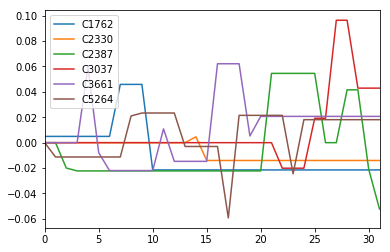

In [52]:
df = sess.run("""
select ReturnCum from returnTick 
        pivot by concatDateTime(Date, Time) as DateTime, Code
""")
df.bfill().iloc[1:].plot()

#### group by all symbol for each day return

In [38]:
sess.run("""
select sum(Return) as Return from returnTick group by Date
""")

,Date,Return
0,2020-07-08,0.493421
1,2020-07-10,-3.126000
2,2020-07-13,-2.224824
3,2020-07-14,5.954466
4,2020-07-15,-0.787402
5,2020-07-16,-2.195609
6,2020-07-17,6.694173
7,2020-07-20,0.189076
8,2020-07-27,1.086957
9,2020-07-28,-1.309446


### Q&A